In [1]:
# required library imports & initial settings

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn import set_config
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning


# set seed value for reproducibility
RANDOM_SEED = 1024

In [2]:
DATA_PATH = './scripts/data/'

df_train_full = pd.read_csv(DATA_PATH+'train_cleaned.csv.gz')
df_test_full  = pd.read_csv(DATA_PATH+'test_cleaned.csv.gz')

df_train_full.head()

,id,cat1,cat2,cat4,cat5,cat6,cat8,cat9,cat10,cat11,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont13,cont14,loss
0,1,A,B,B,A,A,A,B,A,B,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,B,B,A,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.611431,0.304496,1283.60
2,5,A,B,A,B,A,A,B,B,B,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.195709,0.774425,3005.09
3,10,B,B,B,A,A,A,B,A,A,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.605077,0.602642,939.85
4,11,A,B,B,A,A,A,B,B,A,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.246011,0.432606,2763.85


In [3]:
features_numerical   = [column for column in df_train_full if column.startswith('cont')]
features_categorical = [column for column in df_train_full if column.startswith('cat')]

<AxesSubplot:xlabel='loss', ylabel='Count'>

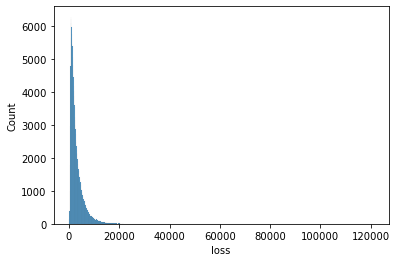

In [4]:
# check-out the target column value distribution before log-transform

name_of_target_column = 'loss'
sns.histplot(df_train_full[name_of_target_column])

In [5]:
name_of_target_column_transformed = name_of_target_column+'_transformed'

# logarithmic transform function
def log_transform(value):
    return np.log1p(value)

# create a new logarithmically transformed target column
df_train_full[name_of_target_column_transformed] = df_train_full.apply(
    lambda row: log_transform(row[name_of_target_column]), axis=1)

<AxesSubplot:xlabel='loss_transformed', ylabel='Count'>

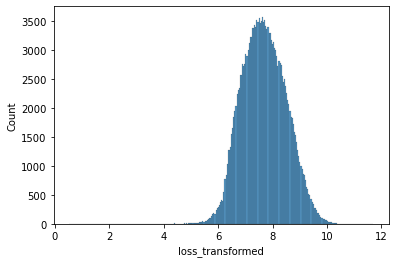

In [6]:
# check value distribution of transformed target column

sns.histplot(df_train_full[name_of_target_column_transformed])

In [7]:
# let's shuffle the whole dataframe before subsampling
df_train_full = df_train_full.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# second shuffle with an exponential random seed :D
df_train_full = df_train_full.sample(frac=1, random_state=(RANDOM_SEED**2)).reset_index(drop=True)

In [8]:
name_of_target_column_binned = name_of_target_column+'_bin'

# 10 bin groups for target values should work fine
bin_counts = 10

# create bin column in our dataframe
df_train_full[name_of_target_column_binned] = pd.qcut(
    df_train_full[name_of_target_column_transformed],
    q=bin_counts,
    labels=list(range(bin_counts)))

In [9]:
desired_subsample_size = 25000
subsample_fold_split = int(len(df_train_full)/desired_subsample_size)

# create desired kfold splitter
skf_subsample_full = StratifiedKFold(
    n_splits=subsample_fold_split, shuffle=True, random_state=RANDOM_SEED)

# make sure target distribution remains the same by utilizing StratifiedKFold data split
train_indices_remaining, train_indices_subsample = next(
    skf_subsample_full.split(X=df_train_full, y=df_train_full[name_of_target_column_binned]), 0)

df_train_full_subsample = df_train_full.iloc[train_indices_subsample, :].reset_index(drop=True)

In [10]:
skf_subsample_trainvalid = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=RANDOM_SEED)

train_indices_subsample, valid_indices_subsample = next(
    skf_subsample_trainvalid.split(X=df_train_full_subsample, y=df_train_full_subsample[name_of_target_column_binned]), 0)

df_train_subsample = df_train_full.iloc[train_indices_subsample, :].reset_index(drop=True)
df_valid_subsample = df_train_full.iloc[valid_indices_subsample, :].reset_index(drop=True)

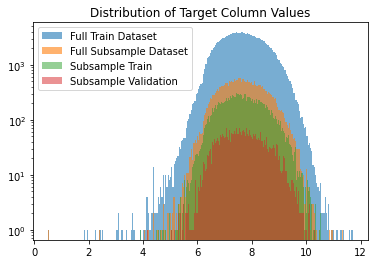

In [11]:
from matplotlib import pyplot as plt

plot_bins = 250

plt.hist(
    x=df_train_full[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.6,
    label='Full Train Dataset')
plt.hist(
    x=df_train_full_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.6,
    label='Full Subsample Dataset')
plt.hist(
    x=df_train_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.5,
    label='Subsample Train')
plt.hist(
    x=df_valid_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.5,
    label='Subsample Validation')

plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Distribution of Target Column Values')
plt.rcParams['figure.figsize'] = (1, 1)
plt.show()

In [12]:
features_all = features_numerical + features_categorical

X_train_subsample = df_train_subsample[features_all].copy()
X_valid_subsample = df_valid_subsample[features_all].copy()

y_train_subsample = df_train_subsample[name_of_target_column_transformed].to_numpy()
y_valid_subsample = df_valid_subsample[name_of_target_column_transformed].to_numpy()

In [13]:
gaussian_like = ['cont1', 'cont2', 'cont3', 'cont6', 'cont7', 'cont9', 'cont11', 'cont12']
non_gaussian_like = ['cont4', 'cont5', 'cont8', 'cont10', 'cont13', 'cont14']

features_numerical_to_normalize = [column for column in gaussian_like if column in df_train_subsample.columns.to_list()]
features_numerical_to_standardize = [column for column in non_gaussian_like if column in df_train_subsample.columns.to_list()]

In [14]:
features_categorical_to_ordinal = list()
features_categorical_to_onehot  = list()

for column, variety in X_train_subsample[features_categorical].nunique().iteritems():
    if variety < 10: features_categorical_to_onehot.append(column)
    else: features_categorical_to_ordinal.append(column)

In [15]:
# create transform pipeline for numerical features
transformer_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normalizer', MinMaxScaler()),
    ('standardizer', StandardScaler()),
])

# create transform pipelines for categorical features
transformer_categorical_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('normal',  MinMaxScaler()),
])
transformer_categorical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  transformer_numerical, features_numerical),
        ('cat1', transformer_categorical_1, features_categorical_to_ordinal),
        ('cat2', transformer_categorical_transformer2, features_categorical_to_onehot),
    ])


# take a look at preprocessing pipeline
set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('normalizer', MinMaxScaler()),
                                                 ('standardizer',
                                                  StandardScaler())]),
                                 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5',
                                  'cont6', 'cont7', 'cont8', 'cont9', 'cont10',
                                  'cont11', 'cont13', 'cont14']),
                                ('cat1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  Ord...
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cat1', 'cat2', 'cat4', 'cat5', 'cat6',
                                  'cat8', 'cat9', 'cat10', 'cat11', 'cat12',
                                  'cat13', 'cat14', 'cat16', 'cat17', 'cat18',
                                  'cat19', 'cat20', 'cat21', 'cat23', 'cat24',
                                  'cat25', 'cat26', 'cat27', 'cat28', 'cat29',
                                  'cat30', 'cat31', 'cat32', 'cat33', 'cat34', ...])])

In [16]:
# ignore regressor converge warning
simplefilter('ignore', category=ConvergenceWarning)


model_hr = HuberRegressor()

# bundle preprocessing and modeling in a final pipeline
pipeline_hr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_hr)
])

# preprocess train data & fit model
pipeline_hr.fit(X_train_subsample, y_train_subsample)


y_pred_subsample_hr = pipeline_hr.predict(X_valid_subsample)

# preprocess validation data and get predictions to evaluate the model
# don't forget to transfer back target values after inference prediction with np.expm1() ;)
score_mae_hr = mean_absolute_error(
    np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_hr))
print('MAE Score:', score_mae_hr)

MAE Score: 1301.5977167053716


In [17]:
tune_subject = 'Alpha (Regularization Parameter)'
tune_values = [0, 1, 10, 100, 200, 300, 400, 500]

scores = list()
print(f'<<MAE Scores for Huber Regression Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_hr = HuberRegressor(alpha=value)
    pipeline_hr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_hr)
    ])
    pipeline_hr.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_hr = pipeline_hr.predict(X_valid_subsample)
    score_mae_hr = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_hr))
    scores.append((value, score_mae_hr))
    print(f'{value} \t {round(score_mae_hr, 4)}')

<<MAE Scores for Huber Regression Model :: Study Parameter: Alpha (Regularization Parameter)>>
Val.	Score
0 	 1300.971
1 	 1300.5205
10 	 1300.4282
100 	 1295.127
200 	 1293.8613
300 	 1293.1329
400 	 1298.2578
500 	 1303.072


In [18]:
tune_subject = 'Alpha (Regularization Parameter)'
tune_values = [round(item, 2) for item in np.arange(2.5, 3.5, 0.1)]

scores = list()
print(f'<<MAE Scores for Huber Regression Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_hr = HuberRegressor(alpha=200, epsilon=value)
    pipeline_hr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_hr)
    ])
    pipeline_hr.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_hr = pipeline_hr.predict(X_valid_subsample)
    score_mae_hr = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_hr))
    scores.append((value, score_mae_hr))
    print(f'{value} \t {round(score_mae_hr, 4)}')

<<MAE Scores for Huber Regression Model :: Study Parameter: Alpha (Regularization Parameter)>>
Val.	Score
2.5 	 1289.6737
2.6 	 1289.8727
2.7 	 1289.3991
2.8 	 1288.1551
2.9 	 1292.1488
3.0 	 1289.3452
3.1 	 1288.7172
3.2 	 1288.6177
3.3 	 1288.6459
3.4 	 1289.142


In [19]:
model_rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

# bundle preprocessing and modeling in a final pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# preprocess train data & fit model
pipeline_rf.fit(X_train_subsample, y_train_subsample)


y_pred_subsample_rf = pipeline_rf.predict(X_valid_subsample)

# preprocess validation data and get predictions to evaluate the model
# don't forget to transfer back target values after inference prediction with np.expm1() ;)
score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_rf))
print('MAE Score:', score_mae_rf)

MAE Score: 1256.4217276244278


In [20]:
tune_subject = 'Max Depth'
tune_values  = [3, 5, 10, 15, 20, 25, 30]

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_rf = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_rf))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')

<<MAE Scores for Random Forest Model :: Study Parameter: Max Depth>>
Val.	Score
3 	 1447.5336
5 	 1348.4137
10 	 1272.5134
15 	 1254.9051
20 	 1255.3437
25 	 1253.8527
30 	 1255.6243


In [21]:
tune_subject = 'Number of Estimators'
tune_values = list(range(50, 300, 50))

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=15, n_estimators=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_rf = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_rf))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')

<<MAE Scores for Random Forest Model :: Study Parameter: Number of Estimators>>
Val.	Score
50 	 1258.2729
100 	 1254.9051
150 	 1254.7139
200 	 1255.0646
250 	 1254.189


In [22]:
tune_subject = 'Max Number of Features for Splitting'
tune_values = [8, 16, 32, 40, 48, 56, 64, 72, 80]

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=15, n_estimators=150,
        max_features=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_rf = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_rf))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')

<<MAE Scores for Random Forest Model :: Study Parameter: Max Number of Features for Splitting>>
Val.	Score
8 	 1317.1715
16 	 1274.3149
32 	 1256.0595
40 	 1255.3021
48 	 1254.0412
56 	 1253.0149
64 	 1247.4436
72 	 1252.0038
80 	 1253.6833


In [23]:
model_xgb = xgb.XGBRegressor()
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_xgb)
])
pipeline_xgb.fit(X_train_subsample, y_train_subsample)

y_pred_subsample_xgb = pipeline_xgb.predict(X_valid_subsample)
score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_xgb))
print('MAE Score:', score_mae_xgb)

MAE Score: 1249.1984325267313


In [24]:
gpu_enabled = True

tree_method_applied = 'gpu_hist' if gpu_enabled else 'auto'

In [25]:
tune_subject = 'Number of Estimators'
tune_values = list(range(20, 100, 5))

scores = list()
print(f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'n_estimators': value,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_xgb = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_xgb))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')

<<MAE Scores for XGBoost Model :: Study Parameter: Number of Estimators>>
Val.	Score


XGBoostError: [14:12:51] d:\bld\xgboost-split_1645118015404\work\src\common\common.h:157: XGBoost version not compiled with GPU support.

In [ ]:
tune_values = list(range(2, 11, 1))

scores = list()
print(
    f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'n_estimators': 35,
        'max_depth': value,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_xgb = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(
        np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_xgb))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')

In [ ]:
tune_subject = 'Learning Rate'
tune_values = [round(item, 2) for item in np.arange(0.1, 0.3, 0.01)]

scores = list()
print(f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'n_estimators': 35,
        'max_depth': 4,
        'eta': value,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample_xgb = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample_xgb))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')

In [ ]:
X_train = df_train_full[features_all].copy()
y_train = df_train_full[name_of_target_column_transformed].to_numpy()
X_test = df_test_full[features_all].copy()


gpu_enabled = True
tree_method_applied = 'gpu_hist' if gpu_enabled else 'auto'

# tuned hyperparameters
xgb_params_final = {
    'n_estimators': 35,
    'max_depth': 4,
    'eta': 0.27,

    'objective': 'reg:squarederror',
    'nthread': -1,
    'tree_method': tree_method_applied,

    'seed': RANDOM_SEED,
    'verbosity': 1,
}

model_final = xgb.XGBRegressor(**xgb_params_final)
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_final)
])
pipeline_final.fit(X_train, y_train)

print('Training finished :)')

In [ ]:
# test the final model on the same subsample validation bunch
y_pred_subsample = pipeline_final.predict(X_valid_subsample)
score_mae_subsample_final = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
print('MAE Score:', score_mae_subsample_final)

In [ ]:
MODEL_PATH = './scripts/model/'

with open(MODEL_PATH+'model.bin', 'wb') as output_file:
   pickle.dump((pipeline_final), output_file)
   print('Model saved successfully.')
output_file.close()